# Fit Demo - NGC 337
------------------------------
Using the Dale et al. (2017) photometry, fit the SED of NGC 337 with a basic model.

## Imports

In [6]:
import numpy as np
rng = np.random.default_rng()
import astropy.units as u
from astropy.table import Table
from corner import corner
import matplotlib.pyplot as plt
plt.style.use('ebm-dejavu')
%matplotlib inline

from lightning import Lightning
from lightning.priors import UniformPrior

## NGC 337
Used in the ["basic" example in the Lightning documentation](https://lightning-sed.readthedocs.io/en/latest/examples/NGC_337_example.html). Compare all the plots.

In [7]:
cat = Table.read('example_photometry/ngc337_dale17_photometry.fits')

# Some annoyance with converting table columns to flat numpy arrays and text encoding:
# strings come in as bytestrings (unencoded) by default python wants UTF-8, I think.
# The labels are also padded with spaces.
filter_labels = np.array([s.decode().strip() for s in cat['FILTER_LABELS'].data[0]])
fnu_obs = cat['FNU_OBS'].data[0]
fnu_unc = cat['FNU_UNC'].data[0]
dl = cat['LUMIN_DIST'].data[0]

l = Lightning(filter_labels, 
              lum_dist=dl, 
              SFH_type='Piecewise-Constant',
              atten_type='Modified-Calzetti',
              dust_emission=True,
              model_unc=0.10,
              print_setup_time=True)

l.flux_obs = fnu_obs * 1e3
l.flux_unc = fnu_unc * 1e3

/Users/Erik/Documents/Research/lightning/plightning/lightning/get_filters.py:61: RuntimeWarning: invalid value encountered in true_divide
  transm_norm_interp = transm_interp / trapz(transm_interp, wave_grid)


0.144 s elapsed in _get_filters
0.001 s elapsed in _get_wave_obs
0.575 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
1.882 s elapsed in dust emission model setup
0.000 s elapsed in agn emission model setup
2.601 s elapsed total


### Fit with `ultranest`

In [15]:
p = np.array([1,1,1,1,1,
              0.3, 0.0, 0.0,
              2, 1, 3e5, 0.1, 0.01])

# Currently the setup is to provide this mask that tells
# lightning which parameters are constant
const_dim = np.array([False, False, False, False, False,
                      False, False, True,
                      True, False, True, False, False])

const_vals = p[const_dim]

# This is a little tedious 
priors = [UniformPrior([0, 1e1]), # SFH
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 3]), # tauV
          UniformPrior([-3, 3]), # delta
          None, # tauV birth cloud
          None, # alpha
          UniformPrior([0.1, 25]), # Umin
          None, # Umax
          UniformPrior([0,1]),
          UniformPrior([0.0047, 0.0458])]

# ultranest wants the parameter names

param_names = [r'$\psi_1$', r'$\psi_2$', r'$\psi_3$', r'$\psi_4$', r'$\psi_5$', 
               r'$\tau_V$', r'$\delta$',
               r'$U_{\rm min}$', r'$\gamma$', r'$q_{\rm PAH}$']


var_dim = ~const_dim

In [10]:
# Will print a semi-cryptic progress bar
res = l.fit(method='ultranest',
            param_names=param_names,
            priors=priors,
            const_dim=const_dim,
            const_vals=const_vals)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9  70 [-9.8637..-9.8633]*| it/evals=13615/908660 eff=1.4990% N=400         
[ultranest] Likelihood function evaluations: 908660
[ultranest]   logZ = -39.07 +- 0.1934
[ultranest] Effective samples strategy satisfied (ESS = 3293.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.19, need <0.5)
[ultranest]   logZ error budget: single: 0.25 bs:0.19 tail:0.01 total:0.19 required:<0.50
[ultranest] done iterating.


In [11]:
res['sampler'].print_results()


logZ = -39.017 +- 0.325
  single instance: logZ = -39.017 +- 0.252
  bootstrapped   : logZ = -39.065 +- 0.325
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    $\psi_1$            : 0.00  │▁▁▄▄▃▃▃▁▁▃▂▁▁▁▁▁▄▄▄▄▆▇▃▂▁▁▁▂▁▂▁▁▁▁▁▁ ▁ │2.41      0.98 +- 0.51
    $\psi_2$            : 0.6   │ ▁▁▁▁▁▂▂▂▁▁▁▁▁▄▇▃▂▁▂▁▁▁▁▁▁▁▁▁▄▂▁▁▁▁▁▁▁ │6.2       3.3 +- 1.1
    $\psi_3$            : 0.00  │▁▁▁▁▁▁▁▁▂▃▃▂▂▂▃▃▃▇▆▂▅▇▂▃▇▆▁▁▁▃▃▁▁▂▃▁▂▁ │5.59      2.94 +- 0.99
    $\psi_4$            : 0.00  │▇▆▄▃▃▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁  ▁      ▁ │2.55      0.41 +- 0.36
    $\psi_5$            : 0.00  │▇▆▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁ ▁▁ │1.94      0.31 +- 0.31
    $\tau_V$            : 0.000 │ ▁▁▁▁▂▃▄▅▆▇▆▆▄▄▄▆▇▅▅▄▃▃▃▂▂▂▁▁▁▁▁▁▁   ▁ │0.513     0.198 +- 0.073
    $\delta$            : -2.91 │ ▁▁▁ ▁▁▁▁▁▁▁▁▁▁▂▂▃▄▄▆▅▆▅▅▆▇▆▅▄▄▂▁▁▁▁▁▁ │0.17      -1.02 +- 0.36
    $U_{\rm min}$       : 1.70  │ ▁▁▁▁▁▁▂▂▄▅▆▇▇▇▇▇▆▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁  ▁ │5.42      3.16 +- 0.42
    $\gamma$      

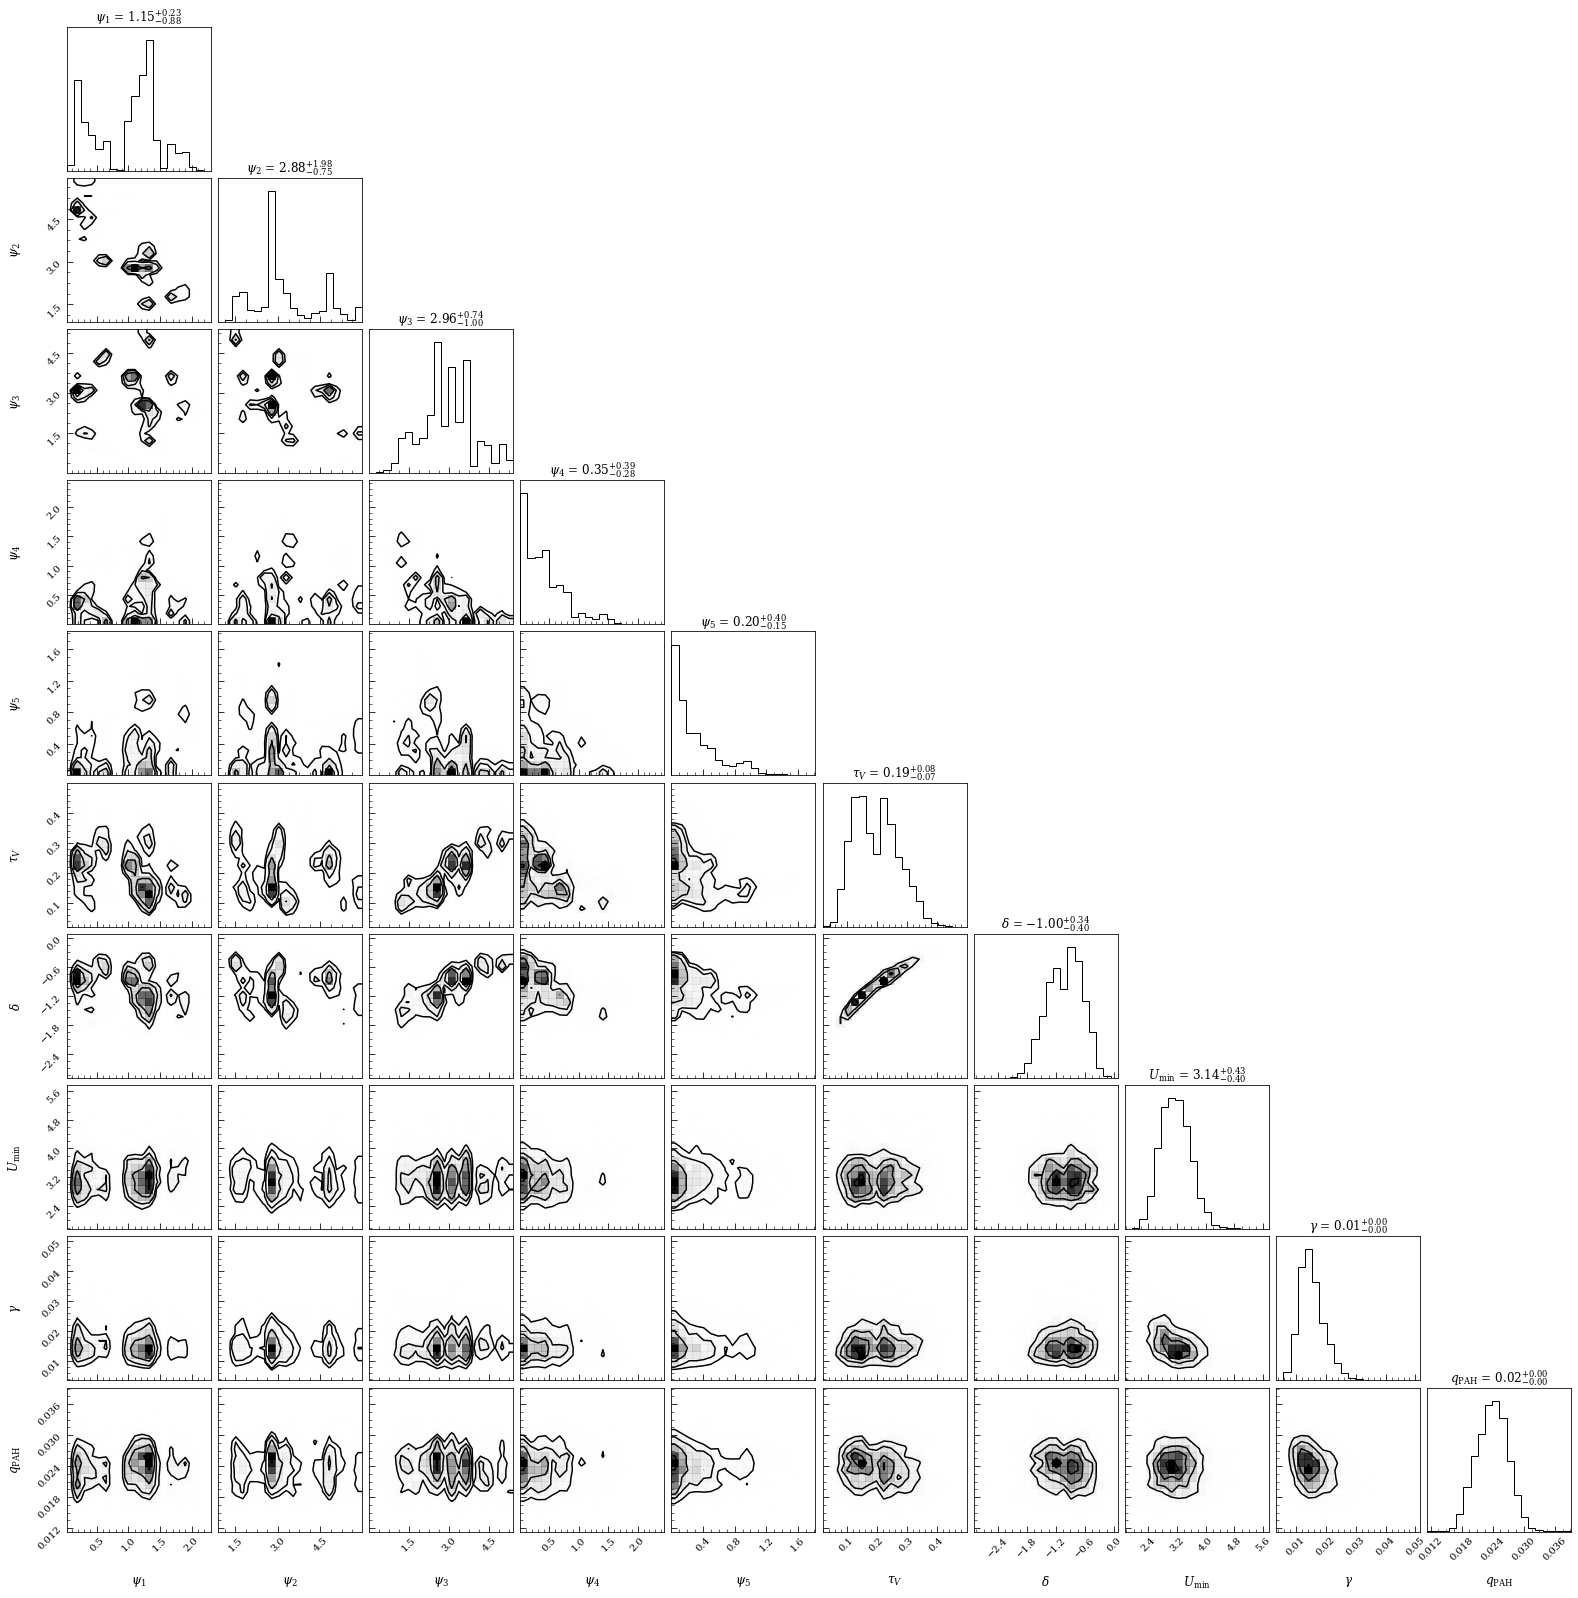

In [12]:
from ultranest.plot import cornerplot
cornerplot(res['result'])

In [12]:
print(res['result'].keys())

dict_keys(['niter', 'logz', 'logzerr', 'logz_bs', 'logz_single', 'logzerr_tail', 'logzerr_bs', 'ess', 'H', 'Herr', 'posterior', 'weighted_samples', 'samples', 'maximum_likelihood', 'ncall', 'paramnames', 'logzerr_single', 'insertion_order_MWW_test'])


Text(0, 0.5, '$\\nu L_{\\nu}\\ [\\rm L_\\odot]$')

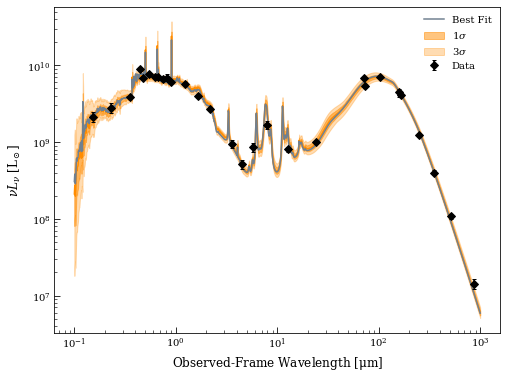

In [33]:
fig, ax = plt.subplots(figsize=(8,6))

sampler = res['sampler']

from ultranest.plot import PredictionBand
wave = l.wave_grid_obs
nu = l.nu_grid_obs
band = PredictionBand(wave)

for params in sampler.results['samples'][:100]:
    params_shape = params.shape
    
    pp = np.zeros((len(p)))
    pp[const_dim] = p[const_dim]
    pp[var_dim] = params
    
    lnu,_ = l.get_model_lnu_hires(pp)
    band.add(nu * lnu)
    
band.shade(color='darkorange', alpha=0.5, label=r'$1\sigma$')
band.shade(q=0.49, color='darkorange', alpha=0.3, label=r'$3\sigma$')
band.line(color='darkorange')

pp = np.zeros((len(p)))
pp[const_dim] = p[const_dim]
pp[var_dim] = sampler.results['maximum_likelihood']['point']
    
lnu,_ = l.get_model_lnu_hires(pp)

ax.plot(wave,
        nu * lnu,
        color='slategray',
        label='Best Fit'
        )

ax.errorbar(l.wave_obs,
            l.nu_obs * l.Lnu_obs,
            yerr=l.nu_obs * l.Lnu_unc,
            marker='D',
            color='k',
            markerfacecolor='k',
            capsize=2.0,
            linestyle='',
            label='Data'
            )

ax.legend(loc='upper right')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Observed-Frame Wavelength $[\rm \mu m]$')
ax.set_ylabel(r'$\nu L_{\nu}\ [\rm L_\odot]$')